In [51]:
import numpy as np
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys

from pandas_profiling import ProfileReport

%matplotlib inline
warnings.simplefilter('ignore')
sns.set()

In [52]:
RANDOM_SEED = 42

In [53]:
cols_to_oh_encode=[]
cols_to_lab_encode=[]
num_cols=[]
cols_to_del_train=[]
cols_to_del_test=[]

In [54]:
# подсчет количества выбросов

def outliers(column): 
    Q1 = column.quantile(0.25)
    Q2 = column.quantile(0.75)
    IQR = Q2 - Q1
    left = Q1 - 1.5 * IQR
    right = Q2 + 1.5 * IQR
    return (column < left).sum() + (column > right).sum(), left, right

In [55]:
data_train=pd.read_csv('data_train.csv')
data_test=pd.read_csv('test.csv')

In [56]:
data_train.head()

,model,url,price,doors_amount,model_year,parsing_unixtime,год выпуска,Пробег,Кузов,Цвет,...,Госномер,Обмен,Кузов №,Запас хода,Статус,fuel_type,enginePower,engineVolume,brand,modelDate
0,Skoda Kodiaq I,https://auto.ru/cars/used/sale/skoda/kodiaq/11...,2 400 000 ₽,5.0,I 2016 – н.в.,1638365394,2019,20 000 км,внедорожник 5 дв.,белый,...,******|126,NaN,NaN,NaN,NaN,Бензин,150 л.с.,1.4 л,Skoda,2016.0
1,Skoda Rapid II,https://auto.ru/cars/used/sale/skoda/rapid/110...,1 525 000 ₽,5.0,II 2020 – н.в.,1638365396,2020,18 890 км,лифтбек,синий,...,NaN,Рассмотрю варианты,NaN,NaN,NaN,Бензин,110 л.с.,1.6 л,Skoda,2020.0
2,Skoda Superb II,https://auto.ru/cars/used/sale/skoda/superb/11...,1 450 000 ₽,5.0,II 2008 – 2013,1638365399,2012,119 730 км,универсал 5 дв.,пурпурный,...,******|197,NaN,NaN,NaN,NaN,Дизель,140 л.с.,2.0 л,Skoda,2008.0
3,Skoda Superb II,https://auto.ru/cars/used/sale/skoda/superb/11...,690 000 ₽,5.0,II 2008 – 2013,1638365402,2011,210 000 км,лифтбек,чёрный,...,******|190,NaN,NaN,NaN,NaN,Бензин,152 л.с.,1.8 л,Skoda,2008.0
4,Skoda Octavia I (A4) Рестайлинг,https://auto.ru/cars/used/sale/skoda/octavia/1...,215 000 ₽,5.0,I (A4) Рестайлинг 2000 – 2011,1638365404,2000,183 800 км,лифтбек,зелёный,...,******|198,NaN,NaN,NaN,NaN,Бензин,150 л.с.,1.8 л,Skoda,2000.0


In [57]:
data_test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [58]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36835 entries, 0 to 36834
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model             36835 non-null  object 
 1   url               36835 non-null  object 
 2   price             36835 non-null  object 
 3   doors_amount      36826 non-null  float64
 4   model_year        36826 non-null  object 
 5   parsing_unixtime  36835 non-null  int64  
 6   год выпуска       36835 non-null  int64  
 7   Пробег            36835 non-null  object 
 8   Кузов             36835 non-null  object 
 9   Цвет              36835 non-null  object 
 10  Двигатель         36835 non-null  object 
 11  Комплектация      29901 non-null  object 
 12  Налог             36046 non-null  object 
 13  Коробка           36835 non-null  object 
 14  Привод            36835 non-null  object 
 15  Руль              36835 non-null  object 
 16  Состояние         36835 non-null  object

In [59]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [60]:
data_train = data_train.rename(columns={'fuel_type': 'fuelType', 'url': 'car_url', 
                                        'doors_amount': 'numberOfDoors', 'Кузов': 'bodyType',
                                        'Цвет': 'color', 'engineVolume': 'engineDisplacement',
                                        'Пробег': 'mileage', 'год выпуска': 'productionDate', 
                                        'Коробка': 'vehicleTransmission'})

In [61]:
#ProfileReport(data_train, title="Pandas Profiling Report for Train Dataset")

In [62]:
#ProfileReport(data_test, title="Pandas Profiling Report for Test Dataset")

In [63]:
# Создадим список с колонками, которые присутствуют и в train, и в test

cols_intersection = list(set(data_test.columns).intersection(data_train.columns))

In [64]:
# Проверим, в каких колонках типы данных различаются у train и test

cols_type_dif = []  
print("Найдены расхождения в типах данных для:")

for col in cols_intersection:
    if type(data_test[col][0]) != type(data_train[col][0]):
        print(
            f"\t- колонки {col}: для train - {type(data_train[col][0])}, для test - {type(data_test[col][0])}")
        cols_type_dif.append(col)

Найдены расхождения в типах данных для:
	- колонки numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки mileage: для train - <class 'str'>, для test - <class 'numpy.int64'>
	- колонки modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	- колонки Владение: для train - <class 'str'>, для test - <class 'float'>


In [65]:
print("Пример значения для train", data_train['modelDate'].sample(1).values)
print("Пример значения для test", data_test['modelDate'].sample(1).values)

Пример значения для train [2011.]
Пример значения для test [1997]


In [66]:
data_train['modelDate']=data_train['modelDate'].astype('Int64')

In [67]:
print("Пример значения для train", data_train['mileage'].sample(1).values)
print("Пример значения для test", data_test['mileage'].sample(1).values)

Пример значения для train ['104 565 км']
Пример значения для test [169723]


In [68]:
# Функция перевеодит формат данных "y yyy км" в количество км.

def num_of_km(row):
    if pd.notnull(row):
        list_km = row.split(' ')
        if len(list_km) == 2: 
            if list_km[1] in ['км']:
                return int(list_km[0])
        return int(list_km[0]+list_km[1])

In [69]:
data_train['mileage'] = data_train['mileage'].apply(num_of_km)

In [70]:
print("Пример значения для train", data_train['numberOfDoors'].sample(1).values)
print("Пример значения для test", data_test['numberOfDoors'].sample(1).values)

Пример значения для train [5.]
Пример значения для test [4]


In [71]:
data_train['numberOfDoors']=data_train['numberOfDoors'].astype('Int64')

In [72]:
# Удалим колонку Владение, потому что в ней очень много пропусков и по смыслу коррелируется информация из Пробега и Дате Выпуска. 

In [73]:
cols_to_del_train.append('Владение')
cols_to_del_test.append('Владение')

In [74]:
cols_intersection

['Таможня',
 'numberOfDoors',
 'enginePower',
 'parsing_unixtime',
 'engineDisplacement',
 'ПТС',
 'mileage',
 'modelDate',
 'Привод',
 'Состояние',
 'bodyType',
 'color',
 'vehicleTransmission',
 'Владение',
 'productionDate',
 'fuelType',
 'Руль',
 'brand',
 'car_url',
 'Владельцы']

# Начнем обработку признаков с цены, а следом с общих признаков в датасетах

# Price

In [75]:
data_train['price'].sample(3)

6307     1 250 000 ₽
2602       435 000 ₽
32627      350 000 ₽
Name: price, dtype: object

In [76]:
data_train['price'] = data_train['price'].str.replace(' ', '')
data_train['price']=data_train['price'].str.replace('₽', '')
data_train = data_train[data_train['price'] != 'sold']
data_train['price']=data_train.price.astype(float).astype('Int64')

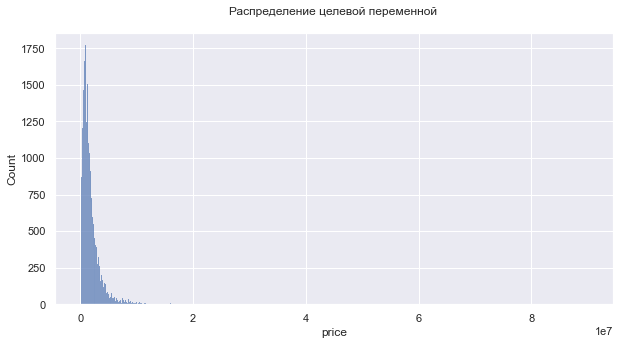

In [77]:
# Посмотрим на распределение целевой переменной
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=data_train, x='price')
plt.title("Распределение целевой переменной \n")
plt.show()

In [78]:
outliers(data_train.price)

(2353, -1532500.0, 4551500.0)

In [79]:
# Посмотрим, какие машины имеют особо высокие цены
data_train[(data_train.price > 4551500.0)].groupby(['brand'])['price'].agg(['count', 'max'])

,count,max
brand,,
BMW,586,90000000
Honda,1,5000001
Infiniti,51,8500000
Lexus,446,23300000
Mercedes-Benz,873,80000000
Mitsubishi,2,7000000
Nissan,3,6999999
Toyota,256,14900000
Volkswagen,64,7200000


Eсть очень дорогие авто, которые представлены и в тестовой выборке. Похоже, что эти бренды могут быть экстренно дорогие. Оставим как есть, можно в будещем попробовать удалить автомобилии с большой ценой, где количество таких автомобилей внутри бренда меньше 10.

<AxesSubplot:>

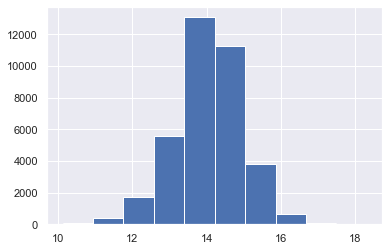

In [80]:
# Распределение цены с очень сильным правым хвостом, посмотрим на признак взяв логорифм от цены

np.log(data_train['price'] + 1).hist()

In [81]:
#Распределение стало намного нормальнее. Отправим признак на стандартизацию

num_cols.append('price')

# Владельцы

In [82]:
print("Значения в train", data_train['Владельцы'].unique())
print("Значения в test", data_test['Владельцы'].unique())

Значения в train ['1 владелец' '3 или более' '2 владельца' nan]
Значения в test ['3 или более' '1\xa0владелец' '2\xa0владельца']


In [83]:
# Удаояем 1 строку с пропуском

data_train.dropna(subset=['Владельцы'], inplace=True)

In [84]:
ownersCount_dict = {'3 или более': 3,
                    '1\xa0владелец': 1,
                    '2\xa0владельца': 2,
                    '1 владелец': 1, 
                    '2 владельца': 2, 
                    '3 или более': 3}

In [85]:
data_test['Владельцы'].replace(
    to_replace=ownersCount_dict, inplace=True)

data_train['Владельцы'].replace(
    to_replace=ownersCount_dict, inplace=True)

In [86]:
print("Значения в train", data_train['Владельцы'].unique())
print("Значения в test", data_test['Владельцы'].unique())

Значения в train [1 3 2]
Значения в test [3 1 2]


In [87]:
data_train['Владельцы']=data_train['Владельцы'].astype('Int64')
data_test['Владельцы']=data_test['Владельцы'].astype('Int64')

In [88]:
print("Значения в train", data_train['Владельцы'].unique())
print("Значения в test", data_test['Владельцы'].unique())

Значения в train <IntegerArray>
[1, 3, 2]
Length: 3, dtype: Int64
Значения в test <IntegerArray>
[3, 1, 2]
Length: 3, dtype: Int64


In [90]:
def break_long_names(names):
    len_name = 12
    short_names = []
    for name in names:
        if type(name) != type('') or len(name) < len_name:
            short_names.append(name)
        else:
            short_names.append(name[:len_name] + '\n' + name[len_name:])
    else:
        return short_names

In [91]:
def plot_cat_col_vs_price(data, col, ylim, num_categories=16):
    values = data[col].value_counts().index
    if len(values) > num_categories:
        values = values[:num_categories]
    values = list(values)
    data_curr_categories = data.query(f"{col} in {values}")
    curr_categories = break_long_names(data_curr_categories[col].values)

    plt.figure()
    sns.boxplot(x=curr_categories, y=data_curr_categories['price'])
    ylim = sorted(ylim)
    plt.ylim(ylim[0], ylim[1])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('price')
    plt.grid()
    plt.show()

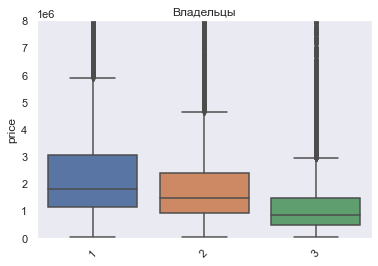

In [92]:
plot_cat_col_vs_price(data_train, 'Владельцы', [0, 8e6])

Логично, что чем меньше владельцев было у машины, тем она младще и тем дороже. 

cols_to_oh_encode.append('Владельцы')

# Car_url

In [94]:
print("Пример значения для train", data_train['car_url'].unique())
print("Пример значения для test", data_test['car_url'].unique())

Пример значения для train ['https://auto.ru/cars/used/sale/skoda/kodiaq/1106065854-e0e3e9d6/'
 'https://auto.ru/cars/used/sale/skoda/rapid/1106020729-f640cb08/'
 'https://auto.ru/cars/used/sale/skoda/superb/1105137525-90afda78/' ...
 'https://auto.ru/cars/used/sale/mercedes/g_klasse_amg/1105870179-abd90fb9/'
 'https://auto.ru/cars/used/sale/mercedes/eqv/1105895074-1c3a9e3d/'
 'https://auto.ru/cars/used/sale/mercedes/s_klasse/1105806540-60f9322f/']
Пример значения для test ['https://auto.ru/cars/used/sale/skoda/octavia/1100575026-c780dc09/'
 'https://auto.ru/cars/used/sale/skoda/octavia/1100549428-595cadf2/'
 'https://auto.ru/cars/used/sale/skoda/superb/1100658222-7ac3def5/' ...
 'https://auto.ru/cars/used/sale/bmw/5er/1101364889-0c6be825/'
 'https://auto.ru/cars/used/sale/bmw/x1/1101362518-34628283/'
 'https://auto.ru/cars/used/sale/bmw/x5/1101256068-ed03accb/']


Отправляем признак в очередь на удаление

In [95]:
cols_to_del_train.append('car_url')
cols_to_del_test.append('car_url')

# Руль

In [96]:
print("Значения в train", data_train['Руль'].unique())
print("Значения в test", data_test['Руль'].unique())

Значения в train ['Левый' 'Правый']
Значения в test ['Левый' 'Правый']


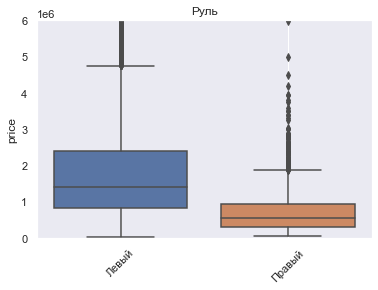

In [98]:
plot_cat_col_vs_price(data_train, 'Руль', [0, 6e6])

In [99]:
cols_to_oh_encode.append('Руль')

# FuelType

In [100]:
print("Статистика значений для train\n", data_train['fuelType'].value_counts())
print("Статистика значений для test\n", data_test['fuelType'].value_counts())

Статистика значений для train
 Бензин                                29528
Дизель                                 5793
Гибрид                                  857
Бензин, газобаллонное оборудование      404
Электро                                  60
Газ, газобаллонное оборудование           1
Гибрид, газобаллонное оборудование        1
Дизель, газобаллонное оборудование        1
Газ                                       1
Name: fuelType, dtype: int64
Статистика значений для test
 бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64


In [101]:
data_train['fuelType'] = data_train.fuelType.apply(lambda x: 'бензин' if x=='Бензин' 
                                                    else 'дизель' if x =='Дизель'
                                                    else 'гибрид' if x == 'Гибрид' 
                                                    else 'электро' if x== 'Электро'
                                                    else 'газ')

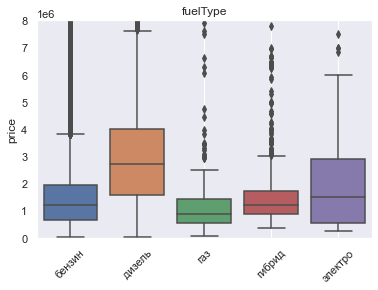

In [103]:
plot_cat_col_vs_price(data_train, 'fuelType', [0, 8e6])

In [104]:
cols_to_lab_encode.append('fuelType')

# Parsing_unixtime

In [105]:
print("Статистика значений для train\n", data_train['parsing_unixtime'].value_counts())
print("Статистика значений для test\n", data_test['parsing_unixtime'].value_counts())

Статистика значений для train
 1638469630    1
1638471016    1
1638673775    1
1638475118    1
1638481261    1
             ..
1638682265    1
1638662837    1
1638470327    1
1638492856    1
1638465536    1
Name: parsing_unixtime, Length: 36646, dtype: int64
Статистика значений для test
 1603274751    1
1603224994    1
1603108229    1
1603233158    1
1603300743    1
             ..
1603289821    1
1603119840    1
1603247872    1
1603242724    1
1603222137    1
Name: parsing_unixtime, Length: 34686, dtype: int64


Parsing_unixtime - время и дата публикации в формате unixtime. Удаляем, так как нет повторяющихся значений, а значит нам ничем он не будет полезен. 

In [106]:
cols_to_del_train.append('parsing_unixtime')
cols_to_del_test.append('parsing_unixtime')

# ProductionDate

In [107]:
print("Значения в train", data_train['productionDate'].unique())
print("Значения в test", data_test['productionDate'].unique())

Значения в train [2019 2020 2012 2011 2000 1998 2015 2017 2007 2013 2014 2016 2001 2008
 2010 2018 2021 2006 2005 2009 2003 1994 2002 1997 1996 1999 2004 1987
 1989 1993 1991 1990 1959 1992 1988 1995 1986 1984 1985 1982 1978 1974
 1979 1981 1968 1980 1983 1948 1939 1975 1976 1960 1971]
Значения в test [2014 2017 2012 2011 2019 2018 2010 2020 2016 2013 2006 2007 2015 2005
 2008 2009 1997 2004 2002 1987 2003 2001 1976 2000 1998 1995 1999 1993
 1939 1996 1984 1990 1991 1992 1989 1982 1985 1994 1938 1981 1988 1983
 1980 1986 1978 1970 1979 1977 1972 1975 1969 1950 1953 1949 1937 1959
 1968 1936 1904 1974 1967 1961 1960 1965 1963 1957 1952 1973 1948]


In [108]:
print("Минимальное значение в train", data_train['productionDate'].min())
print("Минимальное значение в test", data_test['productionDate'].min())

Минимальное значение в train 1939
Минимальное значение в test 1904


Не будем искать и удалять выбросы, так как в тесте тоже есть старые автомобили, цену на которые надо предсказать

<AxesSubplot:>

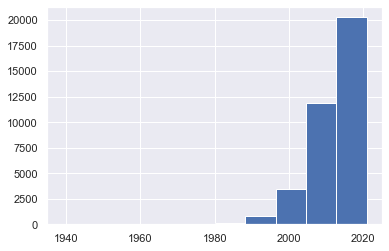

In [109]:
data_train['productionDate'].hist()

<AxesSubplot:>

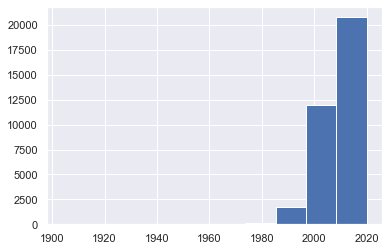

In [110]:
data_test['productionDate'].hist()

Посмотрим как будет выглядеть логарифмированный признак

<AxesSubplot:>

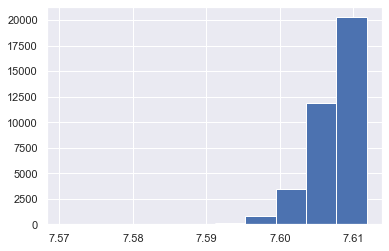

In [111]:
np.log(data_train['productionDate'] + 1).hist()

Особо не изменился. Отправляем на стандартизацию

In [112]:
num_cols.append('productionDate')

# BodyType

In [113]:
print("Статистика значений для train\n", data_train['bodyType'].value_counts())
print("Статистика значений для test\n", data_test['bodyType'].value_counts())

Статистика значений для train
 внедорожник 5 дв.          17076
седан                      10318
лифтбек                     2754
хэтчбек 5 дв.               2304
универсал 5 дв.             1020
минивэн                      955
компактвэн                   678
купе                         557
пикап двойная кабина         308
хэтчбек 3 дв.                263
внедорожник 3 дв.            101
купе-хардтоп                  89
кабриолет                     87
родстер                       50
микровэн                      34
фургон                        30
седан-хардтоп                  7
пикап полуторная кабина        4
седан 2 дв.                    4
пикап одинарная кабина         3
лимузин                        3
внедорожник открытый           1
Name: bodyType, dtype: int64
Статистика значений для test
 седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн            

In [114]:
data_train['bodyType'].replace(regex={r'внедорожник.*': 'внедорожник',
                                r'седан.*': 'седан',
                                r'хэтчбек.*': 'хэтчбек',
                                r'купе.*': 'купе',  r'тарга.*': 'тарга', r'микровэн.*': 'микровэн',
                                r'пикап.*': 'пикап', r'родстер.*': 'родстер',
                                r'универсал.*': 'универсал', r'лифтбек.*': 'лифтбек',
                                r'минивэн.*': 'минивэн', r'компактвэн.*': 'компактвэн',
                                r'лимузин.*': 'лимузин', r'фургон.*': 'фургон', r'кабриолет.*': 'кабриолет'
                                },
                         inplace=True)

In [115]:
data_test['bodyType'].replace(regex={r'внедорожник.*': 'внедорожник',
                                r'седан.*': 'седан',
                                r'хэтчбек.*': 'хэтчбек',
                                r'купе.*': 'купе',  r'тарга.*': 'тарга', r'микровэн.*': 'микровэн',
                                r'пикап.*': 'пикап', r'родстер.*': 'родстер',
                                r'универсал.*': 'универсал', r'лифтбек.*': 'лифтбек',
                                r'минивэн.*': 'минивэн', r'компактвэн.*': 'компактвэн',
                                r'лимузин.*': 'лимузин', r'фургон.*': 'фургон', r'кабриолет.*': 'кабриолет'
                                },
                         inplace=True)

In [116]:
print("Статистика значений для train\n", data_train['bodyType'].value_counts())
print("Статистика значений для test\n", data_test['bodyType'].value_counts())

Статистика значений для train
 внедорожник    17178
седан          10329
лифтбек         2754
хэтчбек         2567
универсал       1020
минивэн          955
компактвэн       678
купе             646
пикап            315
кабриолет         87
родстер           50
микровэн          34
фургон            30
лимузин            3
Name: bodyType, dtype: int64
Статистика значений для test
 седан          13165
внедорожник    12346
хэтчбек         2609
лифтбек         2232
универсал       1276
минивэн          995
купе             982
компактвэн       489
пикап            290
родстер           99
фургон            97
кабриолет         90
микровэн           7
лимузин            6
тарга              2
фастбек            1
Name: bodyType, dtype: int64


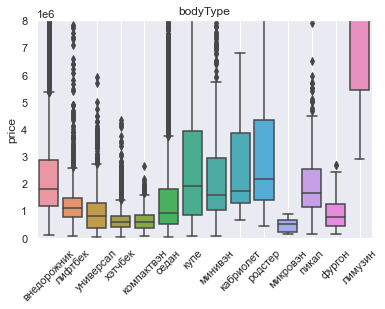

In [118]:
plot_cat_col_vs_price(data_train, 'bodyType', [0, 8e6])

Предлагаю топ 8 типов автомобилей по дороговизне и оформить как отдельный признак

In [119]:
expensive_bodyType=['внедорожник', 'купе', 'микровэн', 'кабриолет', 'родстер', 'пикап', 'лимузин']

In [120]:
data_test['expensive_bodyType']=data_test['bodyType'].apply(lambda x: 1 if x in expensive_bodyType
                                                            else 0)
data_train['expensive_bodyType']=data_train['bodyType'].apply(lambda x: 1 if x in expensive_bodyType
                                                            else 0)

In [121]:
cols_to_lab_encode.append('bodyType')

# Color

In [122]:
print("Статистика значений для train\n", data_train['color'].value_counts())
print("Статистика значений для test\n", data_test['color'].value_counts())

Статистика значений для train
 чёрный         10340
белый           8592
серый           5063
серебристый     3600
синий           3085
коричневый      1716
красный         1643
бежевый          688
зелёный          668
голубой          376
золотистый       225
пурпурный        215
фиолетовый       180
оранжевый        132
жёлтый           115
розовый            8
Name: color, dtype: int64
Статистика значений для test
 чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64


Сделаем новый признак, который будет показывать популярного ли цвета машина. Возмем за популярные цвета: чёрный, белый, 
серебристый, серый, синий, красный и коричневый, так как после них виден явный перепад в кол-ве автомобилей. А признак color удалить. 

In [123]:
data_train['popular_color'] = data_train['color'].apply(lambda x: 1 if x in ['чёрный', 'белый', 
                                                                 'серебристый', 'серый',
                                                                 'синий', 'красный', 'коричневый'] 
                                                    else 0)

In [124]:
data_test['popular_color'] = data_test['color'].apply(lambda x: 1 if x in ['чёрный', 'белый', 
                                                                 'серебристый', 'серый',
                                                                 'синий', 'красный', 'коричневый'] 
                                                    else 0)

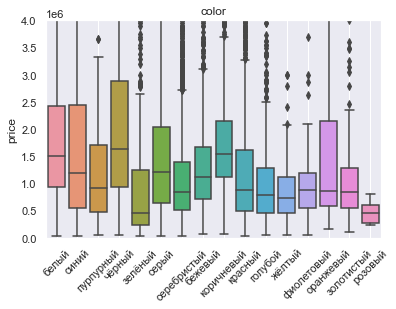

In [125]:
plot_cat_col_vs_price(data_train, 'color', [0, 4e6])

Видим, что популярные цвета обычно и дороже. 

In [126]:
cols_to_del_train.append('color')
cols_to_del_test.append('color')

# ModelDate

In [128]:
print("Значения в train", data_train['modelDate'].unique())
print("Значения в test", data_test['modelDate'].unique())

Значения в train <IntegerArray>
[2016, 2020, 2008, 2000, 1996, 2013, 2017, 2019, 2015, 1999, 2006, 2009, 2007,
 2012, 2010, 2004, 1990, 2001, 1994, 2005, 1998, 2011, 1991, 1993, 1997, 1983,
 1995, 1987, 2002, 2018, 2014, 2003, 1988, 1958, 2021, 1982, 1992, 1989, <NA>,
 1985, 1981, 1979, 1974, 1968, 1975, 1937, 1986, 1976, 1977, 1978, 1957, 1984,
 1971, 1955, 1980, 1967]
Length: 56, dtype: Int64
Значения в test [2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]


In [129]:
data_test['modelDate'] = data_test['modelDate'].astype('Int64')

Оставим этот признак, как и ProductionDate, позже возможно придется выбрать по значимости какой-то один

<AxesSubplot:>

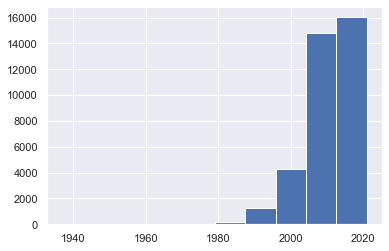

In [130]:
data_train['modelDate'].hist()

<AxesSubplot:>

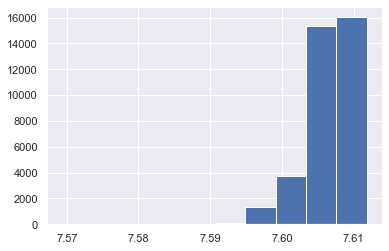

In [131]:
np.log(data_train['modelDate'] + 1).hist()

In [132]:
num_cols.append('modelDate')

# Таможня

In [133]:
print("Значения в train", data_train['Таможня'].unique())
print("Значения в test", data_test['Таможня'].unique())

Значения в train ['Растаможен']
Значения в test ['Растаможен']


Удаляем признак, так как все автомобили растаможены, но в будущем для модели нужно обращать внимание не появились ли не растаможенные автомобили. 

In [134]:
cols_to_del_train.append('Таможня')
cols_to_del_test.append('Таможня')

# Mileage

In [135]:
print("Статистика значений для train\n", data_train['mileage'].value_counts())
print("Статистика значений для test\n", data_test['mileage'].value_counts())

Статистика значений для train
 200000    340
250000    289
300000    270
180000    252
150000    241
         ... 
112856      1
209586      1
10929       1
74416       1
2049        1
Name: mileage, Length: 15697, dtype: int64
Статистика значений для test
 200000    436
150000    382
300000    381
180000    347
250000    346
         ... 
109473      1
299910      1
101253      1
23423       1
73732       1
Name: mileage, Length: 11268, dtype: int64


In [136]:
print("Максимальное значение для train", data_train['mileage'].max())
print("Максимальное значение для test", data_test['mileage'].max())

Максимальное значение для train 999999
Максимальное значение для test 1000000


In [137]:
print("Минимальное значение для train", data_train['mileage'].min())
print("Минимальное значение для test", data_test['mileage'].min())

Минимальное значение для train 1
Минимальное значение для test 1


Так как и в тестовой выборке надо предсказать стоимость автомобиля с большим пробегом, мы опять не будем искать и удалять выбросы. 

<AxesSubplot:>

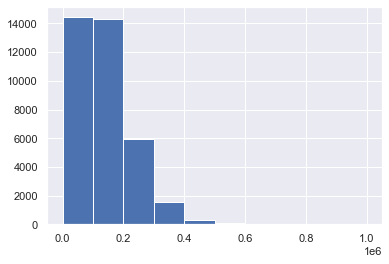

In [138]:
data_train['mileage'].hist()

<AxesSubplot:>

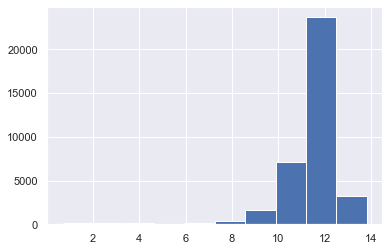

In [139]:
np.log(data_train['mileage'] + 1).hist()

Отправляем на стандартизацию

In [140]:
num_cols.append('mileage')

Еще предлагаю сделать признак который покажет сколько в год пробегала машина, потому что я думаю что есть разница проехала машина Х км за год или 5. 

In [255]:
def km_per_year(row):
    if row['mileage'] != 0:
        # обрабатываем случаи, когда мошина произведена в год сбора данных, чтоб не делить на 0
        if row['productionDate'] == 2021:
            return row['mileage']
        else:
            return row['mileage']/(2021 - row['productionDate'])
    return 0  # возвращаем 0, если машина без пробега (новая)

In [258]:
data_train['km_per_year']=data_train.apply(km_per_year, axis=1)

<AxesSubplot:>

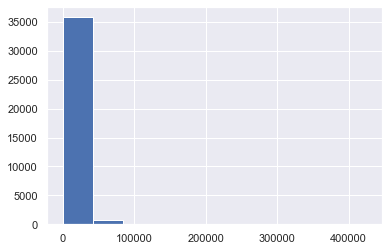

In [261]:
data_train['km_per_year'].hist()

<AxesSubplot:>

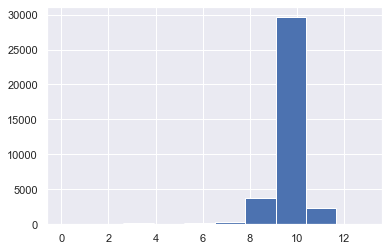

In [262]:
np.log(data_train['km_per_year'] + 1).hist()

In [263]:
num_cols.append('km_per_year')

# NumberOfDoors

In [141]:
print("Статистика значений для train\n", data_train['numberOfDoors'].value_counts())
print("Статистика значений для test\n", data_test['numberOfDoors'].value_counts())

Статистика значений для train
 5    24418
4    11054
2      797
3      368
Name: numberOfDoors, dtype: Int64
Статистика значений для test
 5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64


Автомобиль без двери - возможно это или ошибка или ретро-автомобиль. Ну в любом случае он в тестовой выборке - мы ничего не делаем. 

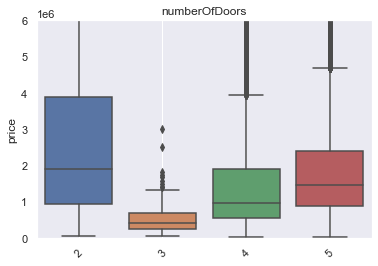

In [142]:
plot_cat_col_vs_price(data_train, 'numberOfDoors', [0, 6e6])

Двухдверные машины это обычно спортиные машины, и они дороже. 

In [143]:
cols_to_oh_encode.append('numberOfDoors')

# EngineDisplacement

In [144]:
print("Значения в train", data_train['engineDisplacement'].unique())
print("Значения в test", data_test['engineDisplacement'].unique())

Значения в train ['1.4 л ' '1.6 л ' '2.0 л ' '1.8 л ' '1.2 л ' '3.6 л ' '1.3 л ' '1.5 л '
 '1.9 л ' '3.5 л ' '2.2 л ' '2.3 л ' '2.4 л ' '1.7 л ' '2.5 л ' '3.2 л '
 '4.4 л ' '2.9 л ' '3.0 л ' '2.8 л ' '0.7 л ' '109 л.с. ' '5.6 л '
 '3.7 л ' '4.5 л ' '2.1 л ' '5.5 л ' '4.2 л ' '6.0 л ' '4.0 л ' '4.7 л '
 '5.4 л ' '1.0 л ' '5.7 л ' '2.7 л ' '3.4 л ' '5.0 л ' '4.3 л ' '4.6 л '
 '4.8 л ' '184 л.с. ' '170 л.с. ' '6.6 л ' '3.3 л ' '3.8 л ' '150 л.с. '
 '218 л.с. ' '4.1 л ' '2.6 л ' '333 л.с. ' '408 л.с. ' '6.2 л ' '5.8 л '
 '179 л.с. ' '204 л.с. ' '136 л.с. ' '74 л.с. ' '1.1 л ' '64 л.с. '
 '67 л.с. ' '41 л.с. ']
Значения в test ['1.2 LTR' '1.6 LTR' '1.8 LTR' '2.0 LTR' '1.4 LTR' '1.3 LTR' '1.0 LTR'
 '3.6 LTR' '1.5 LTR' '1.9 LTR' '2.8 LTR' '1.1 LTR' '2.5 LTR' '4.2 LTR'
 '3.0 LTR' '4.0 LTR' '5.9 LTR' '2.7 LTR' '3.1 LTR' '2.4 LTR' '5.2 LTR'
 '3.2 LTR' '4.1 LTR' '6.3 LTR' '2.3 LTR' '6.0 LTR' '2.2 LTR' '3.7 LTR'
 '2.9 LTR' '5.0 LTR' '3.3 LTR' '2.1 LTR' '2.6 LTR' ' LTR' '3.5 LTR'
 '1.7 LTR' '0.7 LT

In [145]:
data_test[data_test['engineDisplacement']==' LTR'].fuelType.unique()

array(['электро'], dtype=object)

In [146]:
# Для значений 'LTR' заменим на 0, т.к. это электрокары

engineDisplacement_dict = {' LTR':'0.0 LTR'}
                           
data_test['engineDisplacement'].replace(
    to_replace=engineDisplacement_dict, inplace=True)

In [147]:
data_test['engineDisplacement'] = data_test['engineDisplacement'].str.extract(r"(\d\.\d)", expand=True).astype('float')

In [149]:
data_train['engineDisplacement'] = data_train['engineDisplacement'].apply(lambda x: x[:3])

In [150]:
data_train['engineDisplacement'] = data_train['engineDisplacement'].astype('float')

In [151]:
data_train[data_train['engineDisplacement']>10].fuelType.unique()

array(['электро'], dtype=object)

<AxesSubplot:>

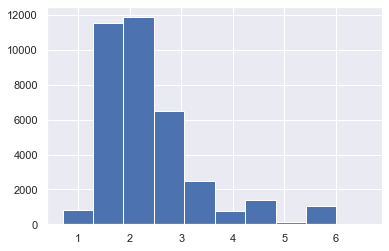

In [152]:
data_train['engineDisplacement'][data_train['engineDisplacement']<10].hist()

<AxesSubplot:>

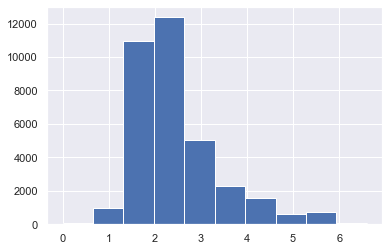

In [153]:
data_test['engineDisplacement'].hist()

In [154]:
# Прировняем значение engineDisplacement для электрокаров к одному виду

data_train['engineDisplacement'][data_train['engineDisplacement']>10]=0.0

In [156]:
num_cols.append('engineDisplacement')

# Привод

In [157]:
print("Значения в train", data_train['Привод'].unique())
print("Значения в test", data_test['Привод'].unique())

Значения в train ['передний' 'полный' 'задний']
Значения в test ['передний' 'полный' 'задний']


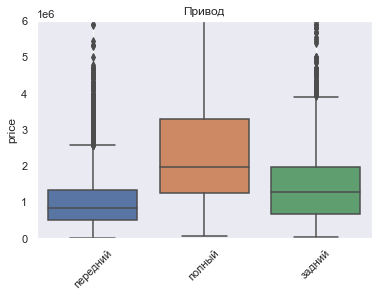

In [159]:
plot_cat_col_vs_price(data_train, 'Привод', [0, 6e6])

In [160]:
cols_to_oh_encode.append('Привод')

# VehicleTransmission

In [161]:
print("Значения в train", data_train['vehicleTransmission'].unique())
print("Значения в test", data_test['vehicleTransmission'].unique())

Значения в train ['роботизированная' 'автоматическая' 'механическая' 'вариатор']
Значения в test ['роботизированная' 'механическая' 'автоматическая' 'вариатор']


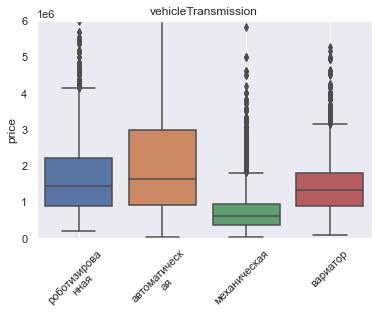

In [163]:
plot_cat_col_vs_price(data_train, 'vehicleTransmission', [0, 6e6])

In [164]:
cols_to_oh_encode.append('vehicleTransmission')

# Brand

In [165]:
print("Значения в train", data_train['brand'].unique())
print("Значения в test", data_test['brand'].unique())

Значения в train ['Skoda' 'Honda' 'Volvo' 'BMW' 'Nissan' 'Infiniti' 'Mercedes-Benz'
 'Toyota' 'Lexus' 'Volkswagen' 'Mitsubishi']
Значения в test ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


In [166]:
print("Значения в train", data_train['brand'].unique())
print("Значения в test", data_test['brand'].unique())

Значения в train ['Skoda' 'Honda' 'Volvo' 'BMW' 'Nissan' 'Infiniti' 'Mercedes-Benz'
 'Toyota' 'Lexus' 'Volkswagen' 'Mitsubishi']
Значения в test ['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


In [167]:
data_train['brand'] = data_train['brand'].str.lower()
data_test['brand'] = data_test['brand'].str.lower()

In [168]:
data_train['brand'][data_train['brand']=='mercedes-benz']='mercedes'

In [169]:
print("Статистика значений для train\n", data_train['brand'].value_counts())
print("Статистика значений для test\n", data_test['brand'].value_counts())

Статистика значений для train
 honda         3841
skoda         3718
nissan        3663
mitsubishi    3663
mercedes      3663
bmw           3663
toyota        3662
volkswagen    3661
lexus         3164
volvo         2442
infiniti      1506
Name: brand, dtype: int64
Статистика значений для test
 bmw           4473
volkswagen    4404
nissan        4393
mercedes      4180
toyota        3913
audi          3421
mitsubishi    2843
skoda         2741
volvo         1463
honda         1150
infiniti       871
lexus          834
Name: brand, dtype: int64


Какие-то популярные топ брендов не выделяется одинаковый и в train и в test. Отправим признак на кодирование.  

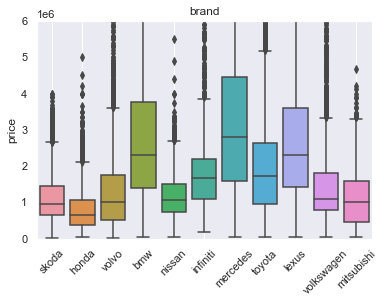

In [171]:
plot_cat_col_vs_price(data_train, 'brand', [0, 6e6])

Предлагаю сделать новый признак о дороговызне машин. Так же, понимая что Audi примерно на том же уровне обыяно, что и BMW, решаю добавить его в премиум-классу. В будущем можно будет попробовать не относить и посмотреть на метрику. 

In [172]:
expensive_brand=['audi', 'bmw', 'infiniti', 'mercedes', 'toyota', 'lexus']

In [173]:
data_test['expensive_brand']=data_test['brand'].apply(lambda x: 1 if x in expensive_brand
                                                            else 0)
data_train['expensive_brand']=data_train['brand'].apply(lambda x: 1 if x in expensive_brand
                                                            else 0)

In [174]:
cols_to_lab_encode.append('brand')

# Состояние

In [175]:
print("Значения в train", data_train['Состояние'].unique())
print("Значения в test", data_test['Состояние'].unique())

Значения в train ['Не требует ремонта']
Значения в test ['Не требует ремонта']


Удаляю признак, так как он имеет только 1 значение, но в будущем нужно обращать внимание на этот признак, возможно появятся еще значения  

In [177]:
cols_to_del_train.append('Состояние')
cols_to_del_test.append('Состояние')

# EnginePower

In [178]:
print("Пример значения для train", data_train['enginePower'].sample(1).values)
print("Пример значения для test", data_test['enginePower'].sample(1).values)

Пример значения для train [' 330 л.с. ']
Пример значения для test ['469 N12']


In [179]:
# Преобразовываем значения столбца, избавляемся от постфиков л.с. и N12
data_train['enginePower'] = data_train['enginePower'].apply(
    lambda x: int(x.split(" ")[1]))
data_test['enginePower'] = data_test['enginePower'].apply(
    lambda x: int(x.split(" ")[0]))

<AxesSubplot:>

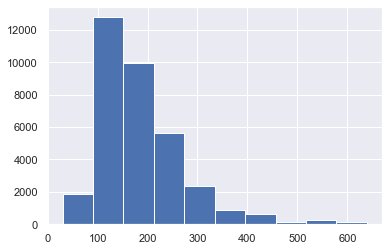

In [180]:
data_test['enginePower'].hist()

<AxesSubplot:>

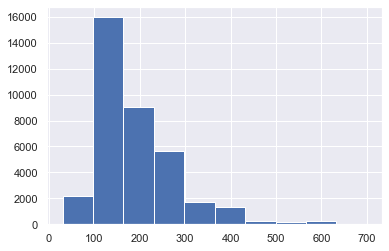

In [181]:
data_train['enginePower'].hist()

Не хороший хвост у графика, посмотрим как будет выглядеть логарифмированный признак

<AxesSubplot:>

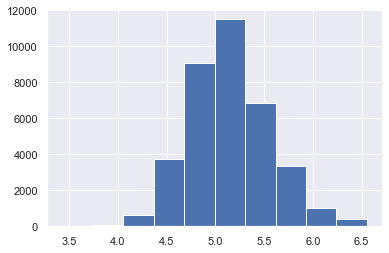

In [182]:
np.log(data_train['enginePower'] + 1).hist()

<AxesSubplot:>

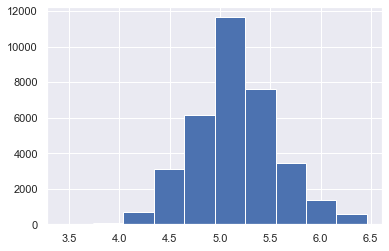

In [183]:
np.log(data_test['enginePower'] + 1).hist()

Так намного лучше! Отправим на стандартизацию

In [185]:
num_cols.append('enginePower')

# ПТС

In [186]:
print("Значения в train", data_train['ПТС'].unique())
print("Значения в test", data_test['ПТС'].unique())

Значения в train ['Оригинал' 'Дубликат']
Значения в test ['Оригинал' 'Дубликат' nan]


In [187]:
print("Заполнено значений в train", data_train['ПТС'].isna().value_counts())
print("Заполнено значений в test", data_test['ПТС'].isna().value_counts())

Заполнено значений в train False    36646
Name: ПТС, dtype: int64
Заполнено значений в test False    34685
True         1
Name: ПТС, dtype: int64


In [188]:
# Пропуск только 1, но он в test, поэтому заменим его на категорию. Выберем 'Дубликат'.

data_test['ПТС']=data_test['ПТС'].fillna('Дубликат')

In [189]:
cols_to_oh_encode.append('ПТС')

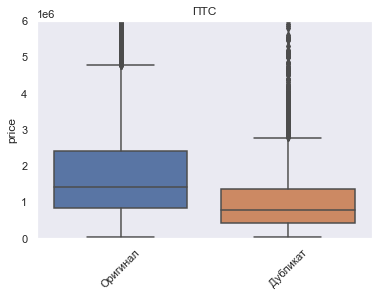

In [190]:
plot_cat_col_vs_price(data_train, 'ПТС', [0, 6e6])

# Обзор признаков, которых нет или в test или в train

In [191]:
# Список колонок, которых нет в test
dif_list_2 = list(set(data_train.columns).difference(data_test.columns))
print("Список колонок, которых нет в test, но есть в train:", dif_list_2)

Список колонок, которых нет в test, но есть в train: ['VIN', 'Запас хода', 'Статус', 'price', 'model_year', 'Налог', 'Кузов №', 'Двигатель', 'model', 'Комплектация', 'Обмен', 'Гарантия', 'Госномер']


In [192]:
# Посмотрим на данные в этих колонках
data_train[dif_list_2].sample(3)

,VIN,Запас хода,Статус,price,model_year,Налог,Кузов №,Двигатель,model,Комплектация,Обмен,Гарантия,Госномер
35885,XW8**************,NaN,NaN,369000,II Рестайлинг 2010 – 2014,1 680 ₽ / год,NaN,"['1.2 л ', ' 70 л.с. ', ' ,Бензин']",Skoda Fabia II Рестайлинг,NaN,NaN,NaN,******|198
13763,NaN,NaN,NaN,490000,VI (R30) 1981 – 1985,840 ₽ / год,HR30***********,"['2.0 л ', ' 120 л.с. ', ' ,Бензин']",Nissan Skyline VI (R30),NaN,NaN,NaN,******|92
17361,WDC**************,NaN,NaN,4199000,I (C292) 2015 – 2019,55 050 ₽ / год,NaN,"['3.0 л ', ' 367 л.с. ', ' ,Бензин']",Mercedes-Benz GLE Coupe 450 AMG I (C292),13 опций,Рассмотрю варианты,До октября 2023,NaN


In [193]:
print("Значения в train", data_train['Запас хода'].unique())

Значения в train [nan '170 км' '175 км' '64 км' '31 км' '200 км' '203 км' '260 км' '3 км'
 '37 км' '130 км' '270 км' '385 км' '199 км' '250 км' '106 км' '770 км'
 '30 км' '445 км' '417 км' '23 км' '2 км' '50 км' '201 км' '54 км'
 '160 км' '150 км']


In [194]:
print("Значения в train", data_train['Налог'].unique())

Значения в train ['2 175 ₽ / год' '2 750 ₽ / год' '4 900 ₽ / год' ... '12 863 ₽ / год'
 '7 585 ₽ / год' '63 900 ₽ / год']


In [195]:
print("Значения в train", data_train['Гарантия'].unique())

Значения в train ['До мая 2022' nan 'До марта 2023' 'До августа 2022' 'До июня 2023'
 'До октября 2022' 'До октября 2024' 'До мая 2025' 'До ноября 2023'
 'До сентября 2022' 'До сентября 2024' 'До декабря 2022' 'До октября 2023'
 'До июля 2022' 'До декабря 2023' 'До сентября 2023' 'До июня 2025'
 'До июня 2022' 'До марта 2024' 'До апреля 2023' 'До июня 2024'
 'До мая 2024' 'До ноября 2024' 'До ноября 2022' 'До июля 2024'
 'До января 2022' 'До апреля 2024' 'До декабря 2021' 'До апреля 2025'
 'До января 2024' 'До августа 2023' 'До февраля 2024' 'До июля 2023'
 'До марта 2022' 'До мая 2023' 'До декабря 2024' 'До февраля 2023'
 'До апреля 2022' 'До июля 2026' 'До декабря 2025' 'До августа 2024'
 'До января 2023' 'До ноября 2021' 'До августа 2025' 'До января 2025'
 'До сентября 2021' 'До декабря 2030' 'До октября 2025' 'До февраля 2022'
 'До ноября 2025' 'До октября 2021' 'До ноября 2026' 'До сентября 2025'
 'До ноября 2030' 'До мая 2026' 'До сентября 2026' 'До августа 2026'
 'До марта 2025'

In [196]:
print("Значения в train", data_train['Кузов №'].unique())

Значения в train [nan 'GP71***********' 'GE6-1***********' 'RA6-1***********'
 'GD11***********' 'RP1-1***********' 'OTSYT***********' 'RN11***********'
 'AK12***********' 'E12***********' 'ZE0-***********' 'BZ11***********'
 'A32***********' 'M910A-0***********' 'JZS141-0***********'
 'JZS1450***********' 'CU4W0***********' 'EA1A0***********'
 '50***********' 'RD11***********' 'GP23***********' 'RG2-1***********'
 'GB31***********' 'HH5-2***********' 'MA41***********' 'JH2-1***********'
 'JF22***********' 'ES11***********' 'RF21***********' 'RC1-1***********'
 'GP7-1***********' 'RC2-1***********' 'RU4-1***********'
 'JG1-***********' 'RB13***********' 'RC4-1***********' 'RC1-***********'
 'EK2-1***********' 'GP11***********' 'RA2-1***********' 'RK11***********'
 'RP3-1***********' 'JF3-1***********' 'RA7-1***********'
 'GP51***********' 'JH1-2***********' 'EK2-3***********'
 'RU3-1***********' 'RA61***********' 'UA2-1***********'
 'TA2-1***********' 'RF31***********' 'GB3-1**********

In [197]:
print("Значения в train", data_train['Обмен'].unique())

Значения в train [nan 'Рассмотрю варианты']


In [198]:
print("Значения в train", data_train['Статус'].unique())

Значения в train [nan 'На заказ']


Жаль таких признаков нет в test. Удалю Госномер, model_year, Кузов №, VIN, Обмен, Статус. Остальные может быть понадобятся для генерации признаков

In [199]:
cols_to_del_train.append('Госномер')
cols_to_del_train.append('model_year')
cols_to_del_train.append('Кузов №')
cols_to_del_train.append('VIN')
cols_to_del_train.append('Обмен')
cols_to_del_train.append('Статус')

In [200]:
# Список колонок, которых нет в train
dif_list = list(set(data_test.columns).difference(data_train.columns))
print("Список колонок, которых нет в train, но есть в test:", dif_list)
    
# Посмотрим на данные в этих колонках
data_test[dif_list].sample(3)

Список колонок, которых нет в train, но есть в test: ['description', 'name', 'vendor', 'priceCurrency', 'vehicleConfiguration', 'model_name', 'model_info', 'image', 'super_gen', 'equipment_dict', 'sell_id', 'complectation_dict']


,description,name,vendor,priceCurrency,vehicleConfiguration,model_name,model_info,image,super_gen,equipment_dict,sell_id,complectation_dict
33250,Выгода от 30 000 руб. при обмене на Ваш автомо...,2.2d AT (150 л.с.) 4WD,JAPANESE,RUB,ALLROAD_5_DOORS AUTOMATIC 2.2,RAV_4,"{""code"":""RAV_4"",""name"":""RAV4"",""ru_name"":""Рав4""...",https://avatars.mds.yandex.net/get-autoru-vos/...,"{""id"":""20702866"",""displacement"":2231,""engine_t...","{""airbag-rear-side"":true,""asr"":true,""airbag-dr...",1101334345,NaN
22348,Продам отличный минивэн (универсал)чистая япош...,1.6 AT (110 л.с.),JAPANESE,RUB,COMPACTVAN AUTOMATIC 1.6,COROLLA_SPACIO,"{""code"":""COROLLA_SPACIO"",""name"":""Corolla Spaci...",https://autoru.naydex.net/imflT9272/520f62I9/2...,"{""id"":""9371282"",""displacement"":1587,""engine_ty...","{""engine-proof"":true,""tinted-glass"":true,""esp""...",1085351762,NaN
23055,"Я собственник, я вписан ПТС.\nКрасивый родной ...",250 2.5 AT (208 л.с.),JAPANESE,RUB,SEDAN AUTOMATIC 2.5,IS,"{""code"":""IS"",""name"":""IS"",""ru_name"":""IS"",""morph...",https://autoru.naydex.net/imflT9272/520f62I9/2...,"{""id"":""20393613"",""name"":""250"",""nameplate"":""250...","{""esp"":true,""airbag-driver"":true,""aux"":true,""w...",1086295422,NaN


Пока что явно можно удалить sell_id и image. С остальными попробую поработать

In [201]:
cols_to_del_test.append('sell_id')
cols_to_del_test.append('image')

# Equipment_dict

In [202]:
data_test['equipment_dict'][5]

'{"cruise-control":true,"tinted-glass":true,"esp":true,"sport-seats":true,"multi-wheel":true,"airbag-passenger":true,"front-centre-armrest":true,"front-seat-support":true,"lock":true,"drl":true,"electro-mirrors":true,"electro-window-back":true,"18-inch-wheels":true,"mirrors-heat":true,"volume-sensor":true,"hatch":true,"combo-interior":true,"cooling-box":true,"music-super":true,"park-assist-r":true,"engine-proof":true,"airbag-driver":true,"aux":true,"isofix":true,"electro-window-front":true,"light-sensor":true,"automatic-lighting-control":true,"computer":true,"seat-transformation":true,"wheel-power":true,"alarm":true,"light-cleaner":true,"alloy-wheel-disks":true,"paint-metallic":true,"ptf":true,"leather-gear-stick":true,"rain-sensor":true,"airbag-side":true,"tyre-pressure":true,"abs":true,"front-seats-heat":true,"wheel-leather":true,"wheel-configuration2":true,"wheel-configuration1":true,"immo":true,"climate-control-1":true}'

К сожалению, ничего не совпадает с train. Удаляем.

In [203]:
cols_to_del_test.append('equipment_dict')

# Name

In [204]:
data_test['name'][5]

'2.0 AMT (200 л.с.)'

Name - дублирует информацию из колонок engineDisplacement, enginePower. Удаляю

In [205]:
cols_to_del_test.append('name')

# Complectation_dict

In [206]:
data_test['complectation_dict'][5]

'{"id":"5011515","name":"RS","available_options":["cruise-control","sport-seats","multi-wheel","airbag-passenger","lock","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","audiopreparation","electro-window-back","condition","music-super","park-assist-r","airbag-driver","isofix","aux","electro-window-front","light-sensor","alarm","paint-metallic","ptf","rain-sensor","tyre-pressure","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo"]}'

Тоже ничего полезного. Удаляю

In [207]:
cols_to_del_test.append('complectation_dict')

# Model_info, model_name и model

Попробуем достать data_train['model'] название модели в соответствии с data_test['model_name'] и на базе этой информации создать новый признак о популярности модели.

In [208]:
data_test['model_info'][5]

'{"code":"OCTAVIA_RS","name":"Octavia RS","ru_name":"Октавия РС","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

In [209]:
data_test['model_name'].value_counts()

OCTAVIA         1418
5ER             1026
LANCER           855
E_KLASSE         809
PASSAT           782
                ... 
920                1
SLC_KLASSE         1
MEGA_CRUISER       1
100NX              1
ATLAS              1
Name: model_name, Length: 544, dtype: int64

In [210]:
data_train['model'].unique()

array(['Skoda Kodiaq I', 'Skoda Rapid II', 'Skoda Superb II', ...,
       'Mercedes-Benz CL-Класс 500 II (C215)',
       'Mercedes-Benz CLS 280 I (C219) Рестайлинг',
       'Mercedes-Benz W123 250'], dtype=object)

In [211]:
data_train['model'] = data_train['model'].apply(
    lambda x: x.split(" ")[1])

In [212]:
data_train['model'].value_counts()

Octavia      1444
Outlander    1153
Polo         1115
RX           1060
Qashqai       890
             ... 
W189            1
Clarity         1
Cynos           1
WiLL            1
Sigma           1
Name: model, Length: 398, dtype: int64

In [213]:
data_train['model'] = data_train['model'].str.lower()
data_test['model_name'] = data_test['model_name'].str.lower()

In [214]:
model_df_train = pd.Series(data_train['model'])
model_df_test = pd.Series(data_test['model_name'])

In [215]:
model_data=pd.concat([model_df_train, model_df_test])

In [216]:
# Определяем популярность по среднему значению частоты встречаний значения в датасетах
model_df = pd.DataFrame(model_data.value_counts())
mean_model = model_data.value_counts().values.mean()

# Добавляем признак во временный датафрейм
model_df['modelPopular'] = model_df[0].apply(
    lambda x: 1 if x >= mean_model else 0)

# Создаем словарь популярности модели
dict_model = model_df.to_dict()['modelPopular']
dict_model_is_popular = {k: v for k, v in dict_model.items() if v == 1}

#Преоюразуем словарь в список
list_model_is_popular=list(dict_model_is_popular)

In [217]:
data_train['modelPopular'] = data_train['model'].apply(lambda x: 1 if x in list_model_is_popular
                                                    else 0)

In [218]:
data_test['modelPopular'] = data_test['model_name'].apply(lambda x: 1 if x in list_model_is_popular
                                                    else 0)

In [219]:
data_train['modelPopular'].value_counts()

1    32634
0     4012
Name: modelPopular, dtype: int64

In [220]:
data_test['modelPopular'].value_counts()

1    29110
0     5576
Name: modelPopular, dtype: int64

Отлично, даже отношение примерно одинаковое. Оставляем признак и удаляем столбцы со значениями модели

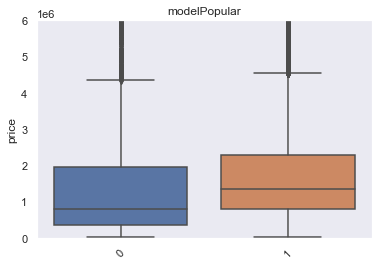

In [221]:
plot_cat_col_vs_price(data_train, 'modelPopular', [0, 6e6])

In [222]:
cols_to_del_test.append('model_name')
cols_to_del_test.append('model_info')
cols_to_del_train.append('model')

# Vendor

In [223]:
data_test['vendor'].unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

Попробуем создать словарь из vendor и brand и по нему создать признак vendor в train.

In [224]:
# Создаем словарь из вендоров по брендам
vendor_dict = data_test.groupby(['vendor'])['brand'].apply(
    lambda grp: list(grp.value_counts().index)).to_dict()
vendor_dict

{'EUROPEAN': ['bmw', 'volkswagen', 'mercedes', 'audi', 'skoda', 'volvo'],
 'JAPANESE': ['nissan', 'toyota', 'mitsubishi', 'honda', 'infiniti', 'lexus']}

In [225]:
dif_list_brands = list(
    set(data_train.brand.unique()).difference(data_test.brand.unique()))
print("Список брендов, которых нет в test, но есть в train:", dif_list_brands)

Список брендов, которых нет в test, но есть в train: []


In [226]:
# Создадим новый словарь для мапинга
new_map = {str(x): str(k) for k, v in vendor_dict.items() for x in v}

In [227]:
# Создаем признак vendor в train
data_train['vendor'] = data_train.brand.copy()
data_train['vendor'] = data_train['vendor'].map(new_map)

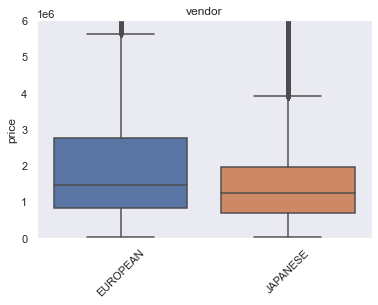

In [228]:
plot_cat_col_vs_price(data_train, 'vendor', [0, 6e6])

In [229]:
cols_to_oh_encode.append('vendor')

# Description

In [230]:
data_test['description'][5]

'Продаю свой автомобиль! Автомобиль полностью исправен и обслужен. Состояние авто отличное. Имеется зимняя резина,новая (отъездил на ней пару месяцев).Автомобиль очень бодрый и динамичный.Прошивку не делал. Все вопросы по телефону! Оригинальный ПТС. Установлен Даунпайп. Установлен Умный отопитель.Кузов в родной краске. Полный комплект ключей и документов. Обмен не интересует.'

Я удалю этот признак, но как идея на будущее - покапаться в описании и возможно можно достать новые признаки из него. 

In [231]:
cols_to_del_test.append('description')

# VehicleConfiguration

In [232]:
data_test['vehicleConfiguration'][5]

'LIFTBACK ROBOT 2.0'

vehicleConfiguration - дублирует информацию из колонок vehicleTransmission, engineDisplacement, bodyType. Удаляю

In [233]:
cols_to_del_test.append('vehicleConfiguration')

# Super_gen

In [234]:
data_test['super_gen'][5]

'{"id":"5009158","displacement":1984,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":200,"power_kvt":147,"human_name":"2.0 AMT (200 л.с.)","acceleration":7.2,"clearance_min":127,"fuel_rate":7.7}'

In [235]:
import ast

data_test['super_gen'] = data_test['super_gen'].apply(
    lambda x: ast.literal_eval(x))

In [236]:
data_test['super_gen'][5]['fuel_rate']

7.7

In [237]:
data_test['fuel_rate']=data_test['super_gen'].copy()

In [238]:
for i in range(0, len(data_test)):
    data_test['fuel_rate'][i] = data_test['super_gen'][i].get('fuel_rate')

<AxesSubplot:>

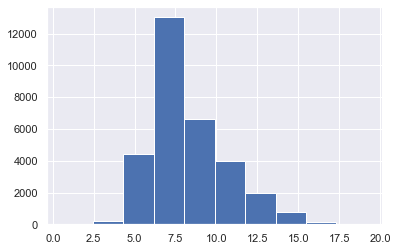

In [239]:
data_test['fuel_rate'].hist()

Похоже, что таких данные нет в train. Как идея на будущее - поискать дополнительные данные по модели автомобиля. Пока что удаляем. признак. 

In [240]:
cols_to_del_test.append('super_gen')
cols_to_del_test.append('fuel_rate')

# PriceCurrency

In [241]:
data_test['priceCurrency'].unique()

array(['RUB'], dtype=object)

Все цены в рублях. Удалим признак

In [242]:
cols_to_del_test.append('priceCurrency')

# Двигатель, Запас хода	, Комплектация, Налог и Гарантия

Удаляем э ти признаки, так как нет полезности в них в итоге на данный момент. Идея на будущее - поискать эти данные в описании

In [243]:
cols_to_del_train.append('Двигатель')
cols_to_del_train.append('Запас хода')
cols_to_del_train.append('Комплектация')
cols_to_del_train.append('Налог')
cols_to_del_train.append('Гарантия')

# Удаляем ненужные колонки

In [244]:
data_train.drop(cols_to_del_train, axis=1, inplace=True)

In [245]:
data_test.drop(cols_to_del_test, axis=1, inplace=True)

# Обработка пропусков

In [265]:
data_train.isnull().sum()

price                  0
numberOfDoors          9
productionDate         0
mileage                0
bodyType               0
vehicleTransmission    0
Привод                 0
Руль                   0
Владельцы              0
ПТС                    0
fuelType               0
enginePower            0
engineDisplacement     0
brand                  0
modelDate              9
expensive_bodyType     0
popular_color          0
expensive_brand        0
modelPopular           0
vendor                 0
km_per_year            0
dtype: int64

Пропусков немного, можем себе позволить удалить строки с пропусками

In [267]:
data_train.dropna(subset=['numberOfDoors'], inplace=True)
data_train.dropna(subset=['modelDate'], inplace=True)

# Обработка выбросов

In [271]:
num_cols

['price',
 'productionDate',
 'modelDate',
 'mileage',
 'engineDisplacement',
 'enginePower',
 'km_per_year']

In [274]:
outliers(data_train['price'])

(2353, -1532500.0, 4551500.0)

In [280]:
print(data_train.loc[data_train['price'] > 4551500.0].modelDate.unique())

<IntegerArray>
[2019, 2018, 2017, 2020, 2015, 2014, 1958, 2008, 2013, 2016, 2021, 2012, 1999,
 1937, 2004, 2011, 1957, 2010, 2003, 1990, 1998, 1955, 2007]
Length: 23, dtype: Int64


В основном это или новые или очень старые (раритетные) машины. Что похоже на правду, поэтому не удаляем выбросы

In [283]:
outliers(data_train['mileage'])

(694, -112500.0, 371500.0)

In [284]:
print(data_train.loc[data_train['mileage'] > 371500.0].modelDate.unique())

<IntegerArray>
[2000, 2013, 2008, 2004, 1993, 1987, 1991, 1995, 2002, 1997, 1999, 2007, 2003,
 2005, 2011, 2001, 1994, 1998, 2006, 1996, 1988, 1989, 1985, 1992, 1983, 1990,
 1974, 1982, 2012, 1986, 1981, 1977, 2014, 2010, 1984, 2009, 2019, 1975]
Length: 38, dtype: Int64


Правктически все очень старые машины, для которых пробег большой - оставляем. 

In [285]:
outliers(data_train['engineDisplacement'])

(1192, -0.34999999999999964, 4.85)

In [287]:
print(data_train.loc[data_train['engineDisplacement'] > 4.85].brand.unique())

['nissan' 'infiniti' 'mercedes' 'toyota' 'lexus' 'bmw']


In [288]:
data_train['engineDisplacement'].max()

6.6

In [289]:
outliers(data_train['enginePower'])

(1231, -26.0, 390.0)

In [290]:
print(data_train.loc[data_train['enginePower'] > 390.0].brand.unique())

['bmw' 'nissan' 'infiniti' 'mercedes' 'lexus' 'volvo' 'toyota']


Одни и те же бренды в выбросах. А так как объем двигателя и его мощность связаны, риску предположить что эти выбросы обоснованы. Оставляем

In [291]:
outliers(data_train['km_per_year'])

(1626, -2692.857142857143, 35535.71428571429)

In [292]:
print(data_train.loc[data_train['km_per_year'] > 35535.71428571429].modelDate.unique())

<IntegerArray>
[2017, 2020, 2012, 2015, 2016, 2013, 2019, 2010, 2008, 2018, 2014, 2005, 2011,
 1995, 2009, 1989, 2003, 2006, 2007, 1998]
Length: 20, dtype: Int64


Большая часть - машины старые, а молодые поэтому и продаются, что пробег сделали большой. Оставляем

# Стандартизация данных